In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [2]:
import sys
sys.path.append(r'c:\Users\ice\projects\iris')

from PIL import Image  # Rename to avoid conflict
from tqdm.notebook import tqdm
import torchvision.transforms as T
import torch
import numpy as np

from iris.config.data_pipeline_config_manager import DataPipelineConfigManager
from iris.config.embedding_pipeline_config_manager import EmbeddingPipelineConfigManager
from iris.data_pipeline.mongodb_manager import MongoDBManager
from iris.embedding_pipeline.embedding_handler import EmbeddingHandler
from iris.embedding_pipeline.embedding_database import EmbeddingDatabase

In [3]:
# Initialize configuration managers
data_config = DataPipelineConfigManager()
embedding_config = EmbeddingPipelineConfigManager()

shop_config = data_config.shop_configs["nikolaj_storm"]  # Select shop
mongodb_config = data_config.mongodb_config

# Create MongoDB manager
mongodb_manager = MongoDBManager(shop_config, mongodb_config)

# Initialize the EmbeddingHandler and Database
embedding_handler = EmbeddingHandler(embedding_config.clip_config)
embedding_db = EmbeddingDatabase(embedding_config.database_config)

In [4]:
def get_augmented_embedding(img, embedding_handler, num_augmentations=5):
    # Define augmentations
    augmentation = T.Compose([
        T.RandomAffine(
            degrees=30,
            translate=(0.1, 0.1),
            scale=(0.8, 1.2),
            shear=15
        ),
        T.RandomHorizontalFlip(p=0.5),
    ])
    
    # Convert PIL image to tensor for transformations
    to_tensor = T.ToTensor()
    to_pil = T.ToPILImage()
    img_tensor = to_tensor(img)
    
    # Get embeddings for original and augmented versions
    embeddings = []
    
    # Get original image embedding and convert to tensor
    orig_embedding = embedding_handler.get_embedding(img)
    embeddings.append(torch.from_numpy(orig_embedding))
    
    # Get augmented versions
    for _ in range(num_augmentations):
        # Apply augmentation
        aug_tensor = augmentation(img_tensor)
        aug_image = to_pil(aug_tensor)
        
        # Get embedding and convert to tensor
        aug_embedding = embedding_handler.get_embedding(aug_image)
        embeddings.append(torch.from_numpy(aug_embedding))
    
    # Stack and average all embeddings
    stacked = torch.stack(embeddings)
    return stacked.mean(dim=0)

In [5]:
# Convert cursor to list since it can only be iterated once
image_dataset = list(mongodb_manager.get_collection(
    mongodb_manager.mongodb_config.image_metadata_collection
).find())

# Add a progress bar with total count
for image_data in tqdm(image_dataset, desc="Processing images", total=len(image_dataset)):
    # Process main image
    with Image.open(image_data['local_path']).convert("RGBA") as img:
        # Use augmented embedding instead of single embedding
        embedding = get_augmented_embedding(img, embedding_handler)
        embedding_db.add_embedding(embedding, id=image_data['image_hash'])
        
        # Process masks if they exist
        if 'masks' in image_data:
            for mask in image_data['masks']:
                # Get bounding box from original image
                bbox = mask['bbox']  # [x, y, width, height]
                bbox_img = img.crop((bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]))
                
                # Use augmented embedding for masks too
                mask_embedding = get_augmented_embedding(bbox_img, embedding_handler)
                embedding_db.add_embedding(mask_embedding, id=mask['mask_hash'])

Processing images:   0%|          | 0/366 [00:00<?, ?it/s]

In [ ]:
# Get the query hash's index and embedding
query_hash = 'f8c10820632963cca58a7be014cbee89'

# Find index of the query hash in the database
hash_index = embedding_db.ids.index(query_hash)
query_embedding = embedding_db.embeddings[hash_index]

# Search for nearest neighbors
results = embedding_db.search(query_embedding, k=50)
print("Nearest neighbors for query hash", query_hash, ":", results)

Nearest neighbors for query hash a136fea9dff98d72dc7ee953d083817e : [('a136fea9dff98d72dc7ee953d083817e', np.float32(0.0)), ('dd0fb509d5ca6cbe07e5e618168ce63b', np.float32(0.10602966)), ('f8c10820632963cca58a7be014cbee89', np.float32(0.13908593)), ('c527e447118e7b4a7f3bd7d94862fb97', np.float32(0.16673875)), ('58b0a579134b12ed6b528d383f6376e6', np.float32(0.20200166)), ('a61fe441ff6dfcc697d898f6e7f9c325', np.float32(0.22490564)), ('410efb7da7a747cf6d07e6a687e8bdf3', np.float32(0.23164874)), ('ff43b236839467c0fc126bb523236c0b', np.float32(0.23303229)), ('6666956892e36909a91dff331d1778d1', np.float32(0.23945452)), ('a1d147c5e8e014f85ab89f7fbb1f9f46', np.float32(0.24417458)), ('eef17deb177de24107cb4a1078ebc4e2', np.float32(0.24478579)), ('d3d92db074a038bd1ab01896222b6fef', np.float32(0.249169)), ('5e839e9ba9f4245af0b98617301af101', np.float32(0.24974838)), ('ef4db136b95827e0a92ea6112afb1cf2', np.float32(0.24992055)), ('04bcc07f149cac3f78fb0db02cbac539', np.float32(0.25473568)), ('8edd928a

In [31]:
import plotly.graph_objects as go
from IPython.display import display, HTML
import base64
from io import BytesIO

def get_hash_source(hash_val):
    """Get source data for a hash (either image path or mask data)"""
    # First check if it's a regular image hash
    for data in image_dataset:
        if data['image_hash'] == hash_val:
            return {'type': 'image', 'path': data['local_path']}
        # Then check if it's a mask hash
        if 'masks' in data:
            for mask in data['masks']:
                if mask['mask_hash'] == hash_val:
                    return {'type': 'mask', 'mask_data': mask, 'parent_image': data}
    return None

def get_image_html(source, size=(100, 140)):
    """Create HTML img tag for either an image path or mask data"""
    if source['type'] == 'image':
        with Image.open(source['path']) as img:
            img.thumbnail(size)
            buffered = BytesIO()
            img.save(buffered, format='JPEG', quality=70)
            img_b64 = base64.b64encode(buffered.getvalue()).decode()
            return f'<img src="data:image/jpeg;base64,{img_b64}" style="max-width:none">'
    else:  # mask
        mask_data = source['mask_data']
        parent_data = source['parent_image']
        
        # Get bounding box from original image
        with Image.open(parent_data['local_path']) as img:
            bbox = mask_data['bbox']  # [x, y, width, height]
            bbox_img = img.crop((bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]))
            bbox_img.thumbnail(size)
            
            buffered = BytesIO()
            bbox_img.save(buffered, format='JPEG', quality=70)
            img_b64 = base64.b64encode(buffered.getvalue()).decode()
            return f'<img src="data:image/jpeg;base64,{img_b64}" style="max-width:none">'


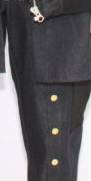
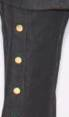
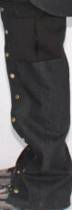
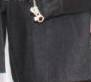
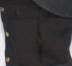
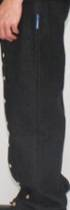
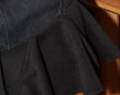
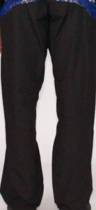
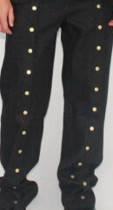
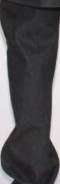
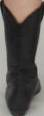
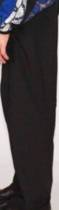
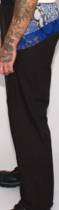
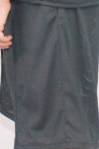
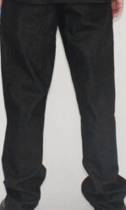
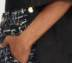
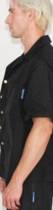
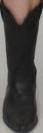
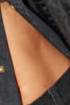
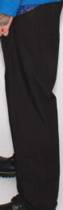
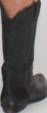
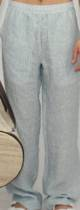
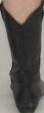
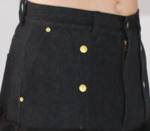
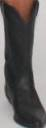
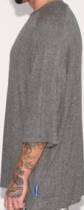
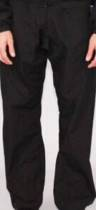
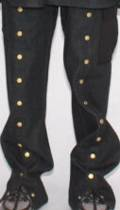
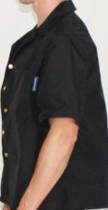
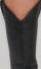
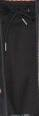
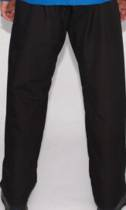
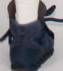
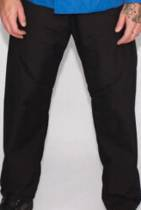
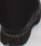
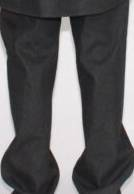
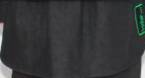
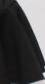
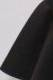
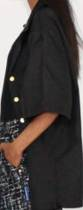
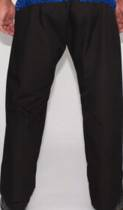
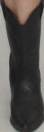
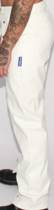
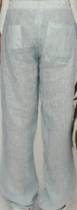
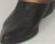
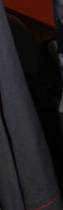
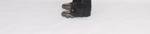
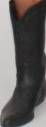
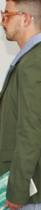

In [32]:
# Extract data for plot
indices = list(range(len(results)))
distances = [dist for _, dist in results]

# Create scatter plot with simpler hover text
fig = go.Figure(data=go.Scatter(
    x=indices,
    y=distances,
    mode='lines+markers',
    marker=dict(size=8),
    text=[f'Index: {i}<br>Hash: {hash_val}<br>Distance: {dist:.4f}' 
          for i, (hash_val, dist) in enumerate(results)],
    hovertemplate='%{text}<extra></extra>'
))

fig.update_layout(
    title='Image Similarity Plot',
    xaxis_title='Index',
    yaxis_title='Distance',
    width=800,
    height=400,
    showlegend=False
)

# Display plot
fig.show()

# Create grid of thumbnails below the plot
html = ['<div style="display: flex; flex-wrap: wrap; gap: 10px;">']

for i, (hash_val, dist) in enumerate(results):
    source = get_hash_source(hash_val)
    if source is None:
        continue

    img_html = get_image_html(source, size=(150, 210))
    item_html = f"""
    <div style='text-align: center; border: 1px solid #ddd; padding: 5px;'>
        {img_html}
        <br>
        <small>Index: {i}</small><br>
        <small>Distance: {dist:.4f}</small><br>
        <small>Hash: {hash_val}</small>
        <small>{'(Mask)' if source['type'] == 'mask' else ''}</small>
    </div>
    """
    html.append(item_html)

html.append('</div>')
display(HTML(''.join(html)))